# Deep learning with EyeFeatures

While building custom models for complex tasks still requires a lot of effort, it would be a waste of time to reinvent the wheel and write a couple of hundreds raws of code to create convenient datasets and dataloaders, make sure that they couple with models and trainers and etc., then launch training CNNs, RNNs, etc. 
Training deep learning models typically requires more effort than using traditional machine learning algorithms and libraries like scikit-learn. However, deep learning models often deliver superior results. The EyeFeatures library simplifies this process for eye-tracking data by providing pre-built Datasets and models, implemented with torch and lightning. These are available in the `eyefeatures.deep.models` and `eyefeatures.deep.datasets` modules.

While building custom models for complex tasks still takes considerable effort, EyeFeatures saves time by eliminating the need to write extensive code for datasets, data loaders, and model-trainer integration, making it easier to train CNNs, RNNs, and other models.




# Datasets

To begin training deep learning models, we first need to choose the data representation to provide to the model later. For scanpath data, there are two main options: images or sequences (specifically, multi-dimensional time series). Images offer greater diversity but may lose some time-related information, while sequences retain the temporal structure of the data but are less variable in form.

When writing `Dataset` we do not mean some specific data but torch lightning `DataModule` class that inherits from `LightningDataModule` and contains `torch.utils.data.Dataset` classes, which implement `__len__` and `__getitem__` methods: more information can be found at: https://lightning.ai/docs/pytorch/stable/data/datamodule.html and https://pytorch.org/tutorials/beginner/basics/data_tutorial.html. 

We begin by loading fixations data (You can find more about data format required by our library at `Preprocessing tutorial` and about dataset used in this tutorial at: https://zenodo.org/records/4655840) and creating specific Dataset which will convert our data to specific representation. 
This class will be responsible for preprocessing of the data, as well as providing it to the model in the desired format suitable for training.

Let's choose dataset which creates 2d representations (more about complex data representations can be found in `Complex representations tutorial`), namely creates heatmap and RGB scanpath graph array for every scanpath stacking these representations along the 2nd (channel) dimension.

In [1]:
from eyefeatures.data.data import Paris_experiment
from eyefeatures.deep.datasets import DatasetLightning2D
import pandas as pd

X, Y, _ = Paris_experiment()
Y = Y.drop(columns='TEXT_TYPE_2') #data contains 2 possible target variables, one of which we drop. 
                                  #Support for multitasking is in development

Y['TEXT_TYPE'] = Y['TEXT_TYPE'].map({'f':0, 'a':1, 'm':2}).astype(int) #encoding str target to int

Y = Y.sample(200) 
X = pd.merge(X, Y, on=['SUBJ_NAME', 'TEXT']) #We remove all except first 200 scanpaths for speed

dataset2d = DatasetLightning2D(
                      X=X, 
                      Y=Y, 
                      x='norm_pos_x', 
                      y='norm_pos_y', 
                      pk=['SUBJ_NAME', 'TEXT'], #Primary keys which together determinate unique sample in common dataframe
                      shape=(16, 16), #Required shape. Can be anything, but remember that bigger images require more computational resources
                      representations=['heatmap', 'baseline_visualization'],
                      test_size = 0.5, 
                      batch_size= 8,
                      split_type = 'simple' #Do not consider distribution of pk when spliting
                      )

# Creating model

Now we need to define CNN model which will process this 4 channel "images". We do not define separate model class for CNN in our library but we provide implemetation of some basic layers like VGG, ResNet etc and utility `make_simple_CNN`. This function takes dictionary with parameters for each layer and creates sequential Convolutional neural network model. 

In [2]:
from eyefeatures.deep.models import create_simple_CNN

CNN_model, output_shape = create_simple_CNN({
                    1:{'type':'VGG_block', 
                      'params':{'out_channels':10}},
                    2:{'type':'VGG_block', 
                      'params':{'out_channels':10}},
                    3:{'type':'Resnet_block', 
                      'params':{'out_channels':10}},
                    4:{'type':'Resnet_block', 
                      'params':{'out_channels':10}}
                      }, in_channels=4, shape=(16,16))

print(f"Output shape of our CNN will be {output_shape}")

100%|██████████| 4/4 [00:00<?, ?it/s]

Output shape of our CNN will be (16, 16)


Now we need to wrap this model into classifier

In [3]:
from eyefeatures.deep.models import Classifier

CNN_classifier = Classifier(CNN_model, 
                   n_classes=len(Y['TEXT_TYPE'].unique()), 
                   classifier_hidden_layers=(25,) #add hidden layer with 25 neurons to classifier head
                   )

c:\Users\toxas\anaconda3\Lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


# Training
The only thing left is to create trainer and fit model which is just couple lines of code! We, also, will use the simplest logger provided by torch lightning - CSVLogger

In [4]:
import pytorch_lightning as pl
from pytorch_lightning.loggers import CSVLogger
from pytorch_lightning.callbacks import TQDMProgressBar
from tqdm import tqdm

logger = CSVLogger("Paris_exeperiment", name="CNN_model") #directory and subdirectory to store losses and metrics

class LitProgressBar(TQDMProgressBar):
    def init_validation_tqdm(self):
        bar = tqdm(disable=True,)
        return bar

tr = pl.Trainer(logger = logger,
                max_epochs=100,
                log_every_n_steps=1,
                callbacks=[LitProgressBar()] #if You use Jupyter in VsCode, 
                )  #You may need this callback to supress redundant progress bars: https://lightning.ai/forums/t/progress-bar-in-jupyter-notebooks-visual-studio-code/4985/5

tr.fit(CNN_classifier, dataset2d)

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
100it [00:00, 958.13it/s]
100%|██████████| 100/100 [00:04<00:00, 24.03it/s]


Number of channels = 4.


100it [00:00, 997.72it/s]
100%|██████████| 100/100 [00:03<00:00, 26.35it/s]
c:\Users\toxas\anaconda3\Lib\site-packages\pytorch_lightning\utilities\model_summary\model_summary.py:461: The total number of parameters detected may be inaccurate because the model contains an instance of `UninitializedParameter`. To get an accurate number, set `self.example_input_array` in your LightningModule.

   | Name            | Type                | Params | Mode 
-----------------------------------------------------------------
0  | backbone        | Sequential          | 5.0 K  | train
1  | head            | ModuleList          | 0      | train
2  | loss_fn         | CrossEntropyLoss    | 0      | train
3  | flat            | Flatten             | 0      | train
4  | accuracy        | MulticlassAccuracy  | 0      | train
5  | precision       | MulticlassPrecision | 0      | train
6  | recall          | MulticlassRecall    | 0      | train
7  | f1              | MulticlassF1Score   | 0      | train
8

Number of channels = 4.


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\toxas\anaconda3\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\toxas\anaconda3\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


Now we can read results as simple csv table with pandas

# Getting results of training

In [5]:
metrics = pd.read_csv('Paris_exeperiment/CNN_model/version_0/metrics.csv')
metrics

,epoch,step,train_loss,val_acc_step,val_f1_class_0,val_f1_class_1,val_f1_class_2,val_macro_f1,val_macro_precision,val_macro_recall,val_precision_class_0,val_precision_class_1,val_precision_class_2,val_recall_class_0,val_recall_class_1,val_recall_class_2,valid_loss
0,0,12,NaN,0.44,0.277714,0.000000,0.543919,0.273878,0.293333,0.372889,0.480000,0.000000,0.400000,0.198667,0.000000,0.920000,1.076805
1,0,12,1.253184,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,25,NaN,0.47,0.332000,0.000000,0.573610,0.301870,0.284127,0.390222,0.390667,0.000000,0.461714,0.330667,0.000000,0.840000,1.035904
3,1,25,1.044438,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2,38,NaN,0.49,0.509435,0.000000,0.534667,0.358290,0.333191,0.448000,0.397238,0.000000,0.577333,0.773333,0.000000,0.530667,1.041226
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
195,97,1273,0.000512,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
196,98,1286,NaN,0.39,0.201905,0.327937,0.408000,0.312614,0.336952,0.358222,0.246667,0.325524,0.438667,0.212000,0.434667,0.428000,3.408892
197,98,1286,0.000978,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
198,99,1299,NaN,0.38,0.201905,0.301270,0.402667,0.301947,0.328064,0.344889,0.246667,0.305524,0.432000,0.212000,0.394667,0.428000,3.363146


You can see NaNs. It happens due to internal operation of CSVLogger, which writes training and validation results to separate rows. For convenience we can split this dataframe to train loss Series and DataFrame with validation loss and metrics.

In [6]:
train_loss = metrics['train_loss'].dropna().reset_index(drop=True)
val_loss_metrics = metrics.drop(columns='train_loss').dropna().reset_index(drop=True)

Now we can easily plot results

<Axes: >

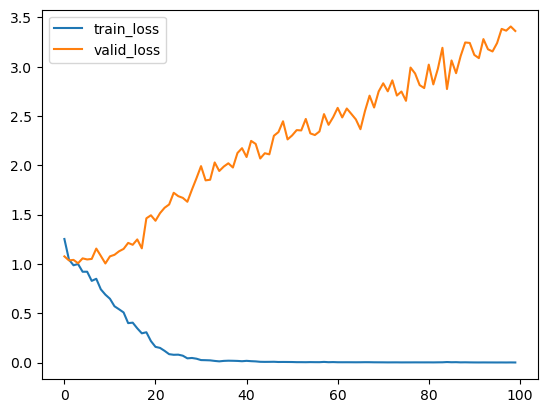

In [7]:
train_loss.plot(legend='train_loss')
val_loss_metrics['valid_loss'].plot(legend='valid_loss')

From the graph we can see that model overfits, which is expected result, because we supplied very little data to model. It important to remember that Neural Networks Usually require more data than classical ML algorithms.

# Training RNNs

In this section we will show how to train RNN model with Dataset for time series, which will present every sample as multidimensional time series [x position of fixation, y position of fixation, duration of fixation] and pad every batch.

In [8]:
from eyefeatures.deep.datasets import DatasetLightningTimeSeries


datasetTime = DatasetLightningTimeSeries(
                      X=X, 
                      Y=Y, 
                      x='norm_pos_x', 
                      y='norm_pos_y', 
                      pk=['SUBJ_NAME', 'TEXT'], #Primary keys which together determinate unique sample in common dataframe
                      features=[],# which additional features to add to coordinate features
                      test_size = 0.5, 
                      batch_size= 8,
                      split_type = 'simple', #Do not consider distribution of pk when spliting
                      max_length=10 # truncate input to first 10 fixations, shorter inputs are truncated
                      )

In [9]:
from eyefeatures.deep.models import SimpleRNN
#create simple RNN of LSTM type
RNN_model = SimpleRNN(
        rnn_type='LSTM', 
        input_size = 2, 
        hidden_size = 64, 
        num_layers=2, 
        bidirectional=False, 
        pre_rnn_linear_size=32
        ) 
#The next step is the same as for CNN model
RNN_classifier = Classifier(RNN_model, 
                   n_classes=len(Y['TEXT_TYPE'].unique()), 
                   classifier_hidden_layers=(25,), #add hidden layer with 25 neurons to classifier head
                   learning_rate = 0.01
                   )

c:\Users\toxas\anaconda3\Lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '


GPU available: False, used: False
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
100%|██████████| 100/100 [00:00<00:00, 1775.81it/s]

   | Name            | Type                | Params | Mode 
-----------------------------------------------------------------
0  | backbone        | SimpleRNN           | 58.5 K | train
1  | head            | ModuleList          | 0      | train
2  | loss_fn         | CrossEntropyLoss    | 0      | train
3  | flat            | Flatten             | 0      | train
4  | accuracy        | MulticlassAccuracy  | 0      | train
5  | precision       | MulticlassPrecision | 0      | train
6  | recall          | MulticlassRecall    | 0      | train
7  | f1              | MulticlassF1Score   | 0      | train
8  | macro_precision | MulticlassPrecision | 0      | train
9  | macro_recall    | MulticlassRecall    | 0      | train
10 | macro_f1        | MulticlassF1Score   | 0      | train
11 | prob            | Softmax             | 0    

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\toxas\anaconda3\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\toxas\anaconda3\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.


<Axes: >

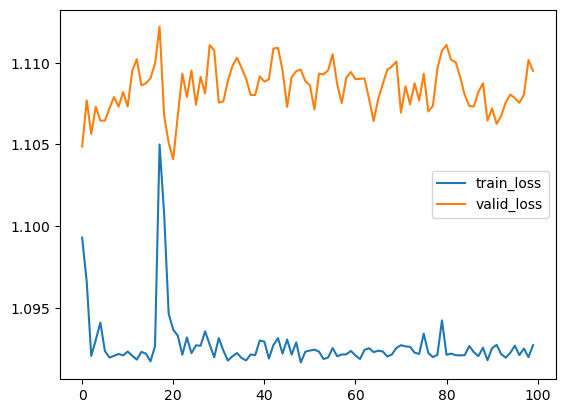

In [10]:
# same steps as before for CNN model
logger = CSVLogger("Paris_exeperiment", name="RNN_model") #directory and subdirectory to store losses and metrics

class LitProgressBar(TQDMProgressBar):
    def init_validation_tqdm(self):
        bar = tqdm(disable=True,)
        return bar

tr = pl.Trainer(logger = logger,
                max_epochs=100,
                log_every_n_steps=1, 
                callbacks=[LitProgressBar()] #if You use Jupyter in VsCode, 
                )  #You may need this callback to supress redundant progress bars: https://lightning.ai/forums/t/progress-bar-in-jupyter-notebooks-visual-studio-code/4985/5

tr.fit(RNN_classifier, datasetTime)

metrics = pd.read_csv('Paris_exeperiment/RNN_model/version_0/metrics.csv')

train_loss = metrics['train_loss'].dropna().reset_index(drop=True)
val_loss_metrics = metrics.drop(columns='train_loss').dropna().reset_index(drop=True)

train_loss.plot(legend='train_loss')
val_loss_metrics['valid_loss'].plot(legend='valid_loss')

Situation is similar here - RNN need more data to learn something and 10 first fixations might be not enough to differentiate between scanpaths, because network strugles to even overfit to training set.

# Combining CNN and RNN

We, also, can combine CNN and RNN as proposed in [Sims et al. 2020](https://dl.acm.org/doi/10.1145/3382507.3418828)

In [11]:
from eyefeatures.deep.datasets import DatasetLightningTimeSeries2D
from eyefeatures.deep.models import VitNet

time2d_dataset = DatasetLightningTimeSeries2D(
                            X=X, 
                            Y=Y, 
                            x='norm_pos_x', 
                            y='norm_pos_y', 
                            pk=['SUBJ_NAME', 'TEXT'], #Primary keys which together determinate unique sample in common dataframe
                            features=[],# which additional features to add to coordinate features
                            test_size = 0.5, 
                            batch_size= 8,
                            shape=(16, 16), #Required shape. Can be anything, but remember that bigger images require more computational resources
                            representations=['heatmap', 'baseline_visualization'],
                            split_type = 'simple', #Do not consider distribution of pk when spliting
                            max_length=10 # truncate input to first 10 fixations
                      )

VitNet_model = VitNet(
                 CNN_model, 
                 RNN_model, 
                 fusion_mode = 'concat', 
                 activation = None, 
                 embed_dim = 32)

VitNet_classifier = Classifier(VitNet_model, 
                   n_classes=len(Y['TEXT_TYPE'].unique()), 
                   classifier_hidden_layers=(25,), #add hidden layer with 25 neurons to classifier head
                   learning_rate = 0.01
                   )


c:\Users\toxas\anaconda3\Lib\site-packages\torch\nn\modules\lazy.py:181: UserWarning: Lazy modules are a new feature under heavy development so changes to the API or functionality can happen at any moment.
  warnings.warn('Lazy modules are a new feature under heavy development '
